## GRU MODEL IMPLEMENTATION WITH MULTIPLE EMBEDDINGS
# E-commerce Product Classification

This notebook implemented GRU-based text classification with 5 different embedding techniques:

 1. **TF-IDF + Dense NN**: Document-level features with feedforward network
 2. **Word2Vec Skip-gram + GRU**: Context-aware word embeddings with sequential modeling
 3. **Word2Vec CBOW + GRU**: Faster training, predicts target from context
 4. **GloVe + GRU**: Pre-trained embeddings capturing global statistics
 5. **FastText + GRU**: Subword information, handles OOV words better

# Each model was evaluated with:
 - Training/validation learning curves
 - Test accuracy, precision, recall, F1-score
 - Confusion matrices
 - Comparative analysis

# 1. Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

!pip install gensim
from gensim.models import Word2Vec, FastText
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 74.6 MB/s eta 0:00:00


# 2. Load Pre-split Data

In [6]:
# Load datasets
train_df = pd.read_csv('/content/train.csv')
val_df = pd.read_csv('/content/validation.csv')
test_df = pd.read_csv('/content/test.csv')

# Print columns to identify the correct label column
print("Columns in train_df:", train_df.columns)
print("Columns in val_df:", val_df.columns)
print("Columns in test_df:", test_df.columns)


Columns in train_df: Index(['text', 'category'], dtype='object')
Columns in val_df: Index(['text', 'category'], dtype='object')
Columns in test_df: Index(['text', 'category'], dtype='object')


In [7]:
X_train = train_df['text'].values
y_train = train_df['category'].values

X_val = val_df['text'].values
y_val = val_df['category'].values

X_test = test_df['text'].values
y_test = test_df['category'].values

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

Training samples: 35317
Validation samples: 7544
Test samples: 7564


 # 3. Encode Labels

In [8]:
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert to categorical
num_classes = len(label_encoder.classes_)
y_train_cat = to_categorical(y_train_encoded, num_classes)
y_val_cat = to_categorical(y_val_encoded, num_classes)
y_test_cat = to_categorical(y_test_encoded, num_classes)

print(f"Number of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")

Number of classes: 4
Classes: ['Books' 'Clothing & Accessories' 'Electronics' 'Household']


# 4. Hyperparameters

In [9]:
# Hyperparameters for e-commerce dataset
MAX_VOCAB_SIZE = 15000
MAX_SEQUENCE_LENGTH = 150
EMBEDDING_DIM = 100

print(f"Max vocabulary size: {MAX_VOCAB_SIZE}")
print(f"Max sequence length: {MAX_SEQUENCE_LENGTH}")
print(f"Embedding dimension: {EMBEDDING_DIM}")

Max vocabulary size: 15000
Max sequence length: 150
Embedding dimension: 100


# 5. Text Tokenization and Sequence Preparation


In [11]:
# Create tokenizer
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Ensure all text data is string type and handle NaN values by converting to pandas Series, filling NaN, then converting back to array
X_train_cleaned = pd.Series(X_train).fillna('').astype(str).values
X_val_cleaned = pd.Series(X_val).fillna('').astype(str).values
X_test_cleaned = pd.Series(X_test).fillna('').astype(str).values

# Convert to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_cleaned)
X_val_seq = tokenizer.texts_to_sequences(X_val_cleaned)
X_test_seq = tokenizer.texts_to_sequences(X_test_cleaned)

# Pad sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

vocab_size = min(len(tokenizer.word_index) + 1, MAX_VOCAB_SIZE)

print(f"Vocabulary size: {vocab_size}")
print(f"Sequence shape (train): {X_train_padded.shape}")
print(f"Sample sequence: {X_train_seq[0][:20]}")

Vocabulary size: 15000
Sequence shape (train): (35317, 150)
Sample sequence: [1820, 13004, 494, 4733, 2, 124, 289, 4126, 858, 691, 1253, 3700, 8455, 1479, 1315, 2823, 4808, 1820, 1, 372]


# 6. Tokenization for Word2Vec and FastText

In [13]:
# Tokenize for Word2Vec and FastText (they need lists of words)
tokenized_train = [text.split() for text in X_train_cleaned]
tokenized_val = [text.split() for text in X_val_cleaned]
tokenized_test = [text.split() for text in X_test_cleaned]

print(f"Sample tokenized text: {tokenized_train[0][:10]}")

Sample tokenized text: ['cambridge', 'checkpoint', 'english', 'workbook', 'book', 'description', 'ensure', 'thorough', 'understanding', 'course']


# 7. GRU Model Architecture and Helper Functions

In [15]:
def create_gru_model(vocab_size, embedding_dim, max_length, num_classes,
                     embedding_matrix=None, trainable_embedding=True):
    """
    Create GRU model for e-commerce data classification
    """
    model = Sequential(name='GRU_Ecommerce')

    # Embedding layer
    if embedding_matrix is not None:
        model.add(Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            input_length=max_length,
            trainable=trainable_embedding
        ))
    else:
        model.add(Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=max_length
        ))

    # GRU layers
    model.add(Bidirectional(GRU(128, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(GRU(64)))
    model.add(Dropout(0.3))

    # Dense layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

def get_callbacks():
    """Training callbacks"""
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )

    return [early_stopping, reduce_lr]

def evaluate_model(model, X_test, y_test, y_test_encoded, label_encoder, model_name):
    """Comprehensive model evaluation"""
    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)

    accuracy = accuracy_score(y_test_encoded, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test_encoded, y_pred, average='weighted'
    )

    cm = confusion_matrix(y_test_encoded, y_pred)

    print(f"\n{'='*60}")
    print(f"{model_name} - Test Results")
    print(f"{'='*60}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    return {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

def plot_training_history(history, model_name):
    """Plot training history"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[0].set_title(f'{model_name} - Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Val Loss')
    axes[1].set_title(f'{model_name} - Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

print(" Helper functions defined")

 Helper functions defined


# 8. EXPERIMENT 1: GRU with TF-IDF
TF-IDF creates document-level features, so we use it with a Dense network rather than GRU for sequential processing.


EXPERIMENT 1: TF-IDF with Dense Neural Network
TF-IDF shapes - Train: (35317, 5000), Val: (7544, 5000), Test: (7564, 5000)
Sparsity: 99.2%

Training TF-IDF model...
Epoch 1/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.8070 - loss: 0.5016 - val_accuracy: 0.9669 - val_loss: 0.1182 - learning_rate: 0.0010
Epoch 2/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9761 - loss: 0.0910 - val_accuracy: 0.9735 - val_loss: 0.1044 - learning_rate: 0.0010
Epoch 3/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9860 - loss: 0.0512 - val_accuracy: 0.9722 - val_loss: 0.1086 - learning_rate: 0.0010
Epoch 4/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9919 - loss: 0.0323 - val_accuracy: 0.9755 - val_loss: 0.1118 - learning_rate: 0.0010
Epoch 5/20
542/552 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9929 - loss: 0.0244
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
552/552 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9929 - l

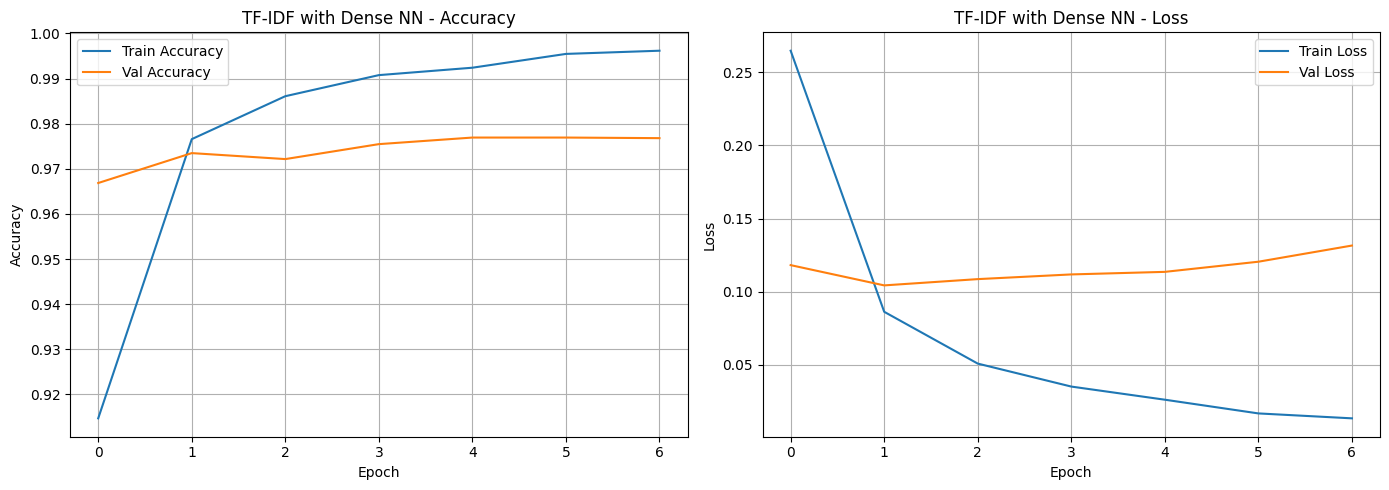


TF-IDF with Dense NN - Test Results
Accuracy:  0.9724
Precision: 0.9724
Recall:    0.9724
F1-Score:  0.9724


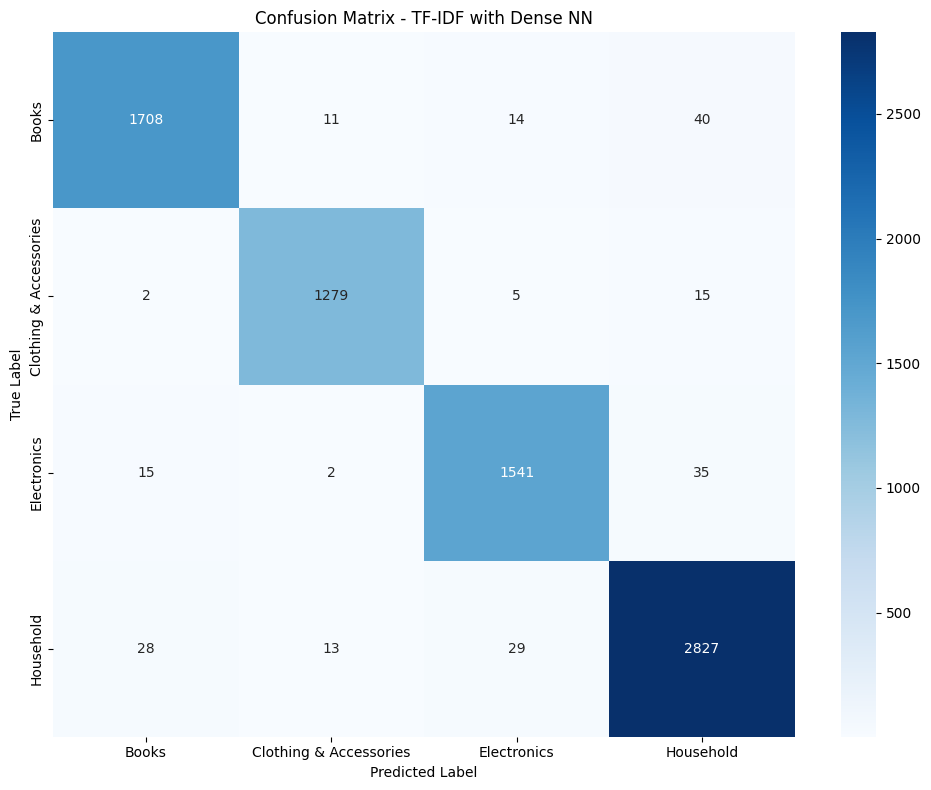

In [17]:
print("EXPERIMENT 1: TF-IDF with Dense Neural Network")
print("="*60)

# Vectorize text with TF-IDF
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    strip_accents='unicode',
    lowercase=True,
    stop_words='english'
)

X_train_tfidf = tfidf.fit_transform(X_train_cleaned).toarray()
X_val_tfidf = tfidf.transform(X_val_cleaned).toarray()
X_test_tfidf = tfidf.transform(X_test_cleaned).toarray()

print(f"TF-IDF shapes - Train: {X_train_tfidf.shape}, Val: {X_val_tfidf.shape}, Test: {X_test_tfidf.shape}")
print(f"Sparsity: {(X_train_tfidf == 0).sum() / X_train_tfidf.size * 100:.1f}%")

# Build model (Dense NN, not GRU)
model_tfidf = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_tfidf.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
], name='TF-IDF_DenseNN')

model_tfidf.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nTraining TF-IDF model...")
history_tfidf = model_tfidf.fit(
    X_train_tfidf, y_train_cat,
    validation_data=(X_val_tfidf, y_val_cat),
    epochs=20,
    batch_size=64,
    callbacks=get_callbacks(),
    verbose=1
)

plot_training_history(history_tfidf, 'TF-IDF with Dense NN')

results_tfidf = evaluate_model(
    model_tfidf, X_test_tfidf, y_test_cat,
    y_test_encoded, label_encoder, 'TF-IDF with Dense NN'
)

# 9. EXPERIMENT 2: GRU with Word2Vec Skip-gram


EXPERIMENT 2: GRU with Word2Vec Skip-gram

Training Word2Vec Skip-gram...
 Trained! Vocabulary size: 38097
Embedding coverage: 99.99% (14998/14999)


Model: "GRU_Ecommerce"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,500,000 (5.72 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,500,000 (5.72 MB)


Training GRU with Skip-gram embeddings...
Epoch 1/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.8746 - loss: 0.3976 - val_accuracy: 0.9536 - val_loss: 0.1688 - learning_rate: 0.0010
Epoch 2/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - accuracy: 0.9516 - loss: 0.1885 - val_accuracy: 0.9557 - val_loss: 0.1462 - learning_rate: 0.0010
Epoch 3/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.9588 - loss: 0.1534 - val_accuracy: 0.9646 - val_loss: 0.1246 - learning_rate: 0.0010
Epoch 4/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 32s 58ms/step - accuracy: 0.9684 - loss: 0.1230 - val_accuracy: 0.9649 - val_loss: 0.1158 - learning_rate: 0.0010
Epoch 5/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.9737 - loss: 0.1041 - val_accuracy: 0.9692 - val_loss: 0.1051 - learning_rate: 0.0010
Epoch 6/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - accuracy: 0.9762 - loss: 0.0884 - val_accuracy: 0.9692 - val_loss: 0.1104 - learning_rate: 0.0010
Epoch 7/20
552/552 ━━━━━━━━━━━━━━

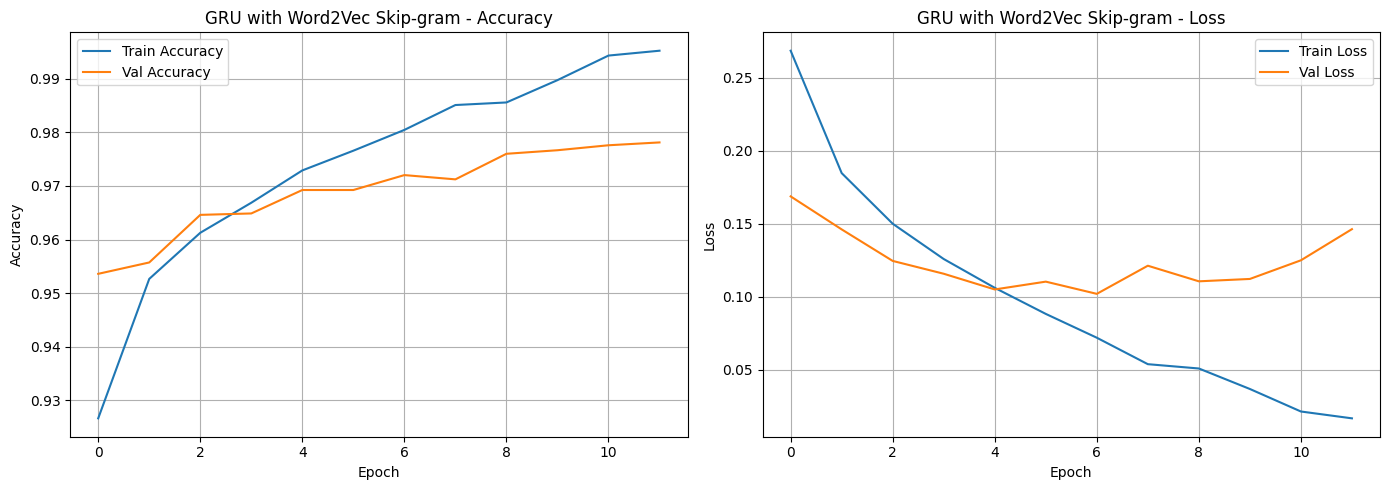


GRU with Word2Vec Skip-gram - Test Results
Accuracy:  0.9742
Precision: 0.9745
Recall:    0.9742
F1-Score:  0.9743


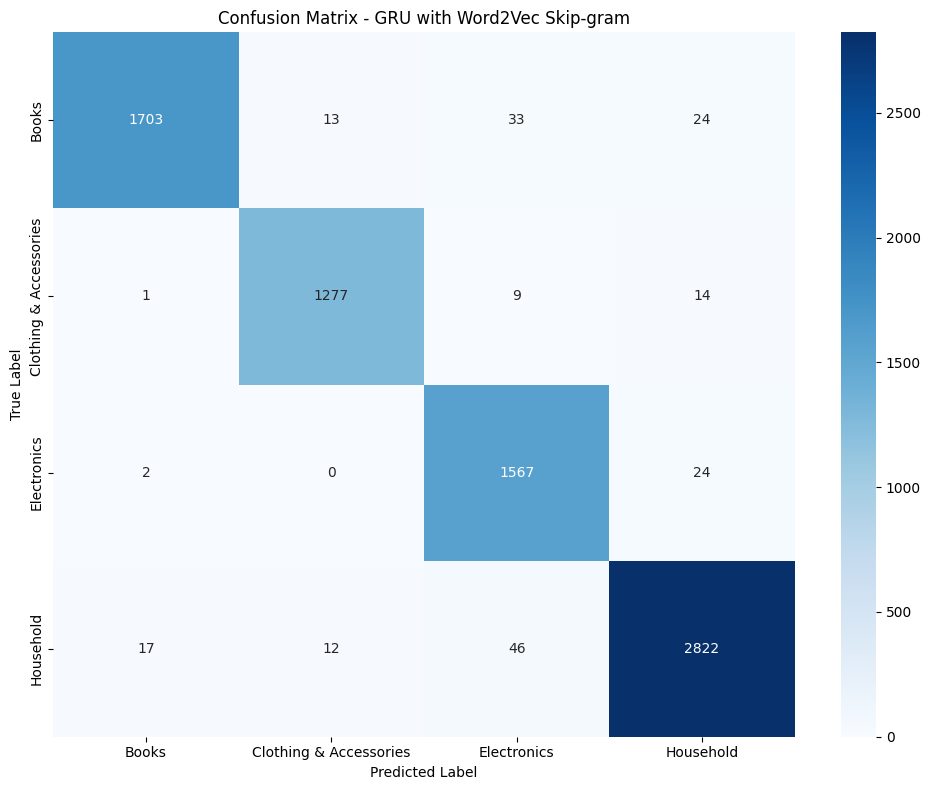

In [18]:
print("EXPERIMENT 2: GRU with Word2Vec Skip-gram")
print("="*60)

# Train Word2Vec Skip-gram
print("\nTraining Word2Vec Skip-gram...")
w2v_skipgram = Word2Vec(
    sentences=tokenized_train,
    vector_size=EMBEDDING_DIM,
    window=5,
    min_count=2,
    workers=4,
    sg=1,  # Skip-gram
    epochs=20,
    seed=42
)

print(f" Trained! Vocabulary size: {len(w2v_skipgram.wv)}")

# Create embedding matrix
embedding_matrix_skipgram = np.zeros((vocab_size, EMBEDDING_DIM))
hits, misses = 0, 0

for word, idx in tokenizer.word_index.items():
    if idx < vocab_size:
        try:
            embedding_matrix_skipgram[idx] = w2v_skipgram.wv[word]
            hits += 1
        except KeyError:
            embedding_matrix_skipgram[idx] = np.random.normal(0, 0.1, EMBEDDING_DIM)
            misses += 1

print(f"Embedding coverage: {hits/(hits+misses)*100:.2f}% ({hits}/{hits+misses})")

# Create and train model
model_skipgram = create_gru_model(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    max_length=MAX_SEQUENCE_LENGTH,
    num_classes=num_classes,
    embedding_matrix=embedding_matrix_skipgram,
    trainable_embedding=False
)

model_skipgram.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_skipgram.summary()

print("\nTraining GRU with Skip-gram embeddings...")
history_skipgram = model_skipgram.fit(
    X_train_padded, y_train_cat,
    validation_data=(X_val_padded, y_val_cat),
    epochs=20,
    batch_size=64,
    callbacks=get_callbacks(),
    verbose=1
)

plot_training_history(history_skipgram, 'GRU with Word2Vec Skip-gram')

results_skipgram = evaluate_model(
    model_skipgram, X_test_padded, y_test_cat,
    y_test_encoded, label_encoder, 'GRU with Word2Vec Skip-gram'
)

# 10. EXPERIMENT 3: GRU with Word2Vec CBOW

EXPERIMENT 3: GRU with Word2Vec CBOW

Training Word2Vec CBOW...
 Trained! Vocabulary size: 38097
Embedding coverage: 99.99% (14998/14999)

Training GRU with CBOW embeddings...
Epoch 1/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 35s 48ms/step - accuracy: 0.8733 - loss: 0.4007 - val_accuracy: 0.9576 - val_loss: 0.1457 - learning_rate: 0.0010
Epoch 2/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 32s 31ms/step - accuracy: 0.9592 - loss: 0.1548 - val_accuracy: 0.9663 - val_loss: 0.1183 - learning_rate: 0.0010
Epoch 3/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.9713 - loss: 0.1108 - val_accuracy: 0.9686 - val_loss: 0.1141 - learning_rate: 0.0010
Epoch 4/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - accuracy: 0.9825 - loss: 0.0711 - val_accuracy: 0.9745 - val_loss: 0.1064 - learning_rate: 0.0010
Epoch 5/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - accuracy: 0.9855 - loss: 0.0519 - val_accuracy: 0.9740 - val_loss: 0.1052 - learning_rate: 0.0010
Epoch 6/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step 

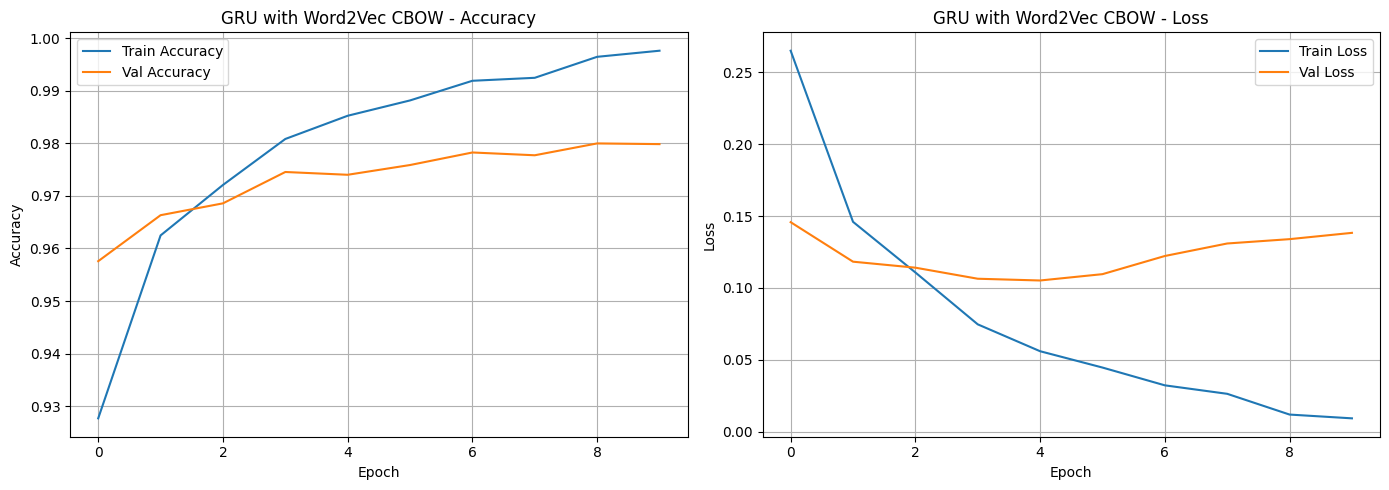


GRU with Word2Vec CBOW - Test Results
Accuracy:  0.9754
Precision: 0.9755
Recall:    0.9754
F1-Score:  0.9754


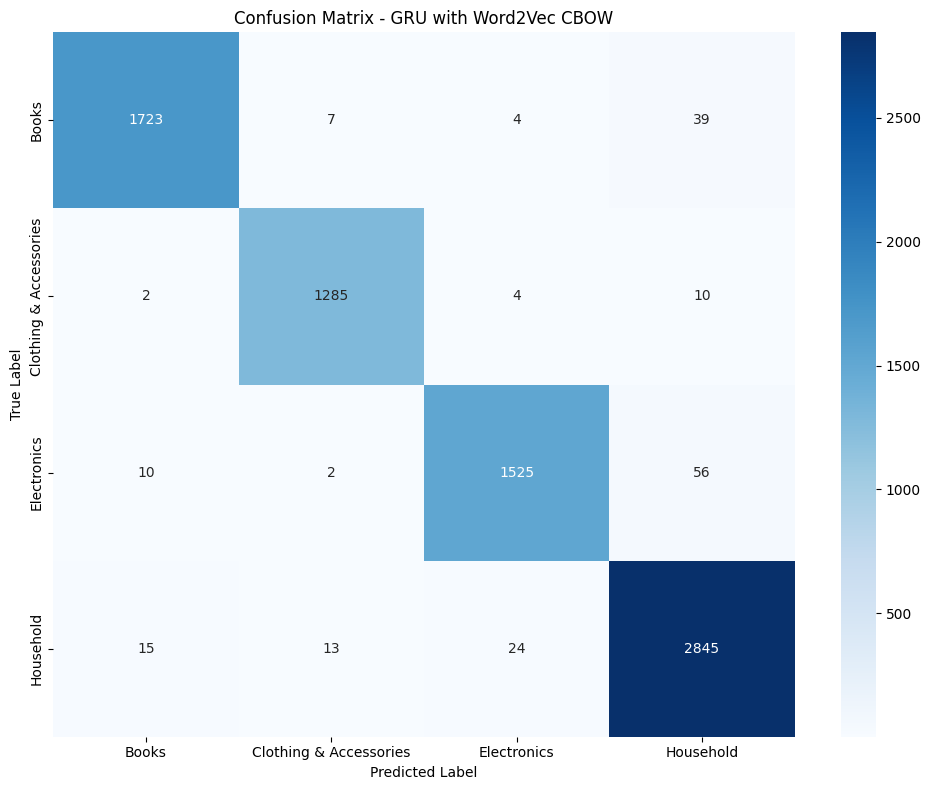

In [19]:
print("EXPERIMENT 3: GRU with Word2Vec CBOW")
print("="*60)

# Train Word2Vec CBOW
print("\nTraining Word2Vec CBOW...")
w2v_cbow = Word2Vec(
    sentences=tokenized_train,
    vector_size=EMBEDDING_DIM,
    window=5,
    min_count=2,
    workers=4,
    sg=0,  # CBOW
    epochs=20,
    seed=42
)

print(f" Trained! Vocabulary size: {len(w2v_cbow.wv)}")

# Create embedding matrix
embedding_matrix_cbow = np.zeros((vocab_size, EMBEDDING_DIM))
hits, misses = 0, 0

for word, idx in tokenizer.word_index.items():
    if idx < vocab_size:
        try:
            embedding_matrix_cbow[idx] = w2v_cbow.wv[word]
            hits += 1
        except KeyError:
            embedding_matrix_cbow[idx] = np.random.normal(0, 0.1, EMBEDDING_DIM)
            misses += 1

print(f"Embedding coverage: {hits/(hits+misses)*100:.2f}% ({hits}/{hits+misses})")

# Create and train model
model_cbow = create_gru_model(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    max_length=MAX_SEQUENCE_LENGTH,
    num_classes=num_classes,
    embedding_matrix=embedding_matrix_cbow,
    trainable_embedding=False
)

model_cbow.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nTraining GRU with CBOW embeddings...")
history_cbow = model_cbow.fit(
    X_train_padded, y_train_cat,
    validation_data=(X_val_padded, y_val_cat),
    epochs=20,
    batch_size=64,
    callbacks=get_callbacks(),
    verbose=1
)

plot_training_history(history_cbow, 'GRU with Word2Vec CBOW')

results_cbow = evaluate_model(
    model_cbow, X_test_padded, y_test_cat,
    y_test_encoded, label_encoder, 'GRU with Word2Vec CBOW'
)

# 11. EXPERIMENT 4: GRU with GloVe

EXPERIMENT 4: GRU with GloVe

Loading GloVe embeddings...
 Loaded 147359 word vectors
GloVe coverage: 88.28% (13241/14999)

Training GRU with GloVe embeddings...
Epoch 1/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.8422 - loss: 0.4810 - val_accuracy: 0.9386 - val_loss: 0.2021 - learning_rate: 0.0010
Epoch 2/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.9442 - loss: 0.2169 - val_accuracy: 0.9524 - val_loss: 0.1580 - learning_rate: 0.0010
Epoch 3/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - accuracy: 0.9591 - loss: 0.1546 - val_accuracy: 0.9576 - val_loss: 0.1501 - learning_rate: 0.0010
Epoch 4/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.9651 - loss: 0.1307 - val_accuracy: 0.9643 - val_loss: 0.1305 - learning_rate: 0.0010
Epoch 5/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - accuracy: 0.9717 - loss: 0.0996 - val_accuracy: 0.9683 - val_loss: 0.1252 - learning_rate: 0.0010
Epoch 6/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.

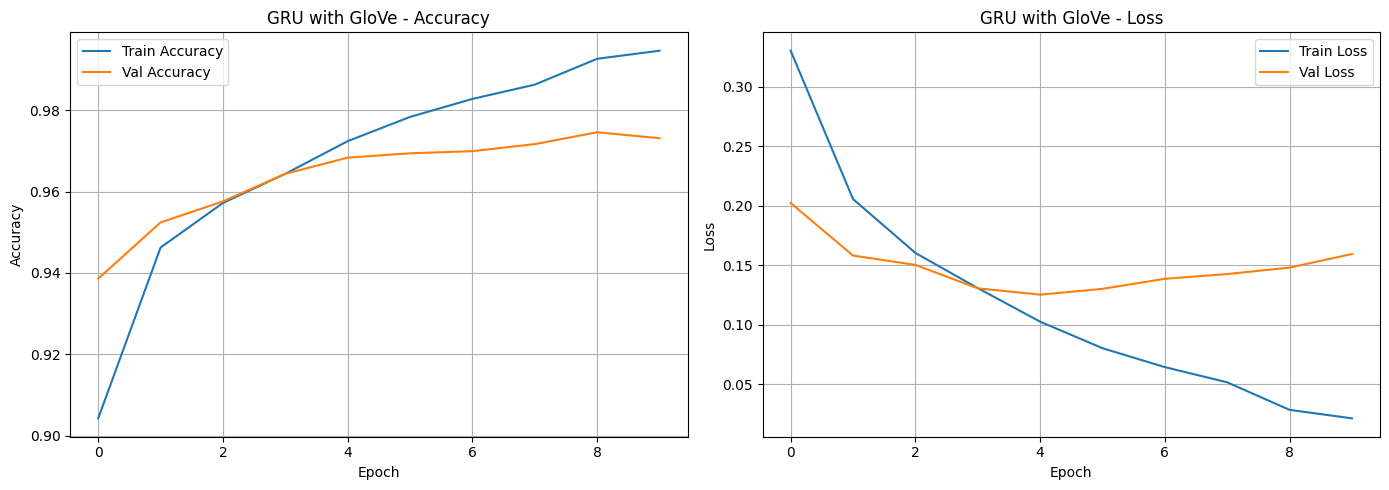


GRU with GloVe - Test Results
Accuracy:  0.9648
Precision: 0.9651
Recall:    0.9648
F1-Score:  0.9648


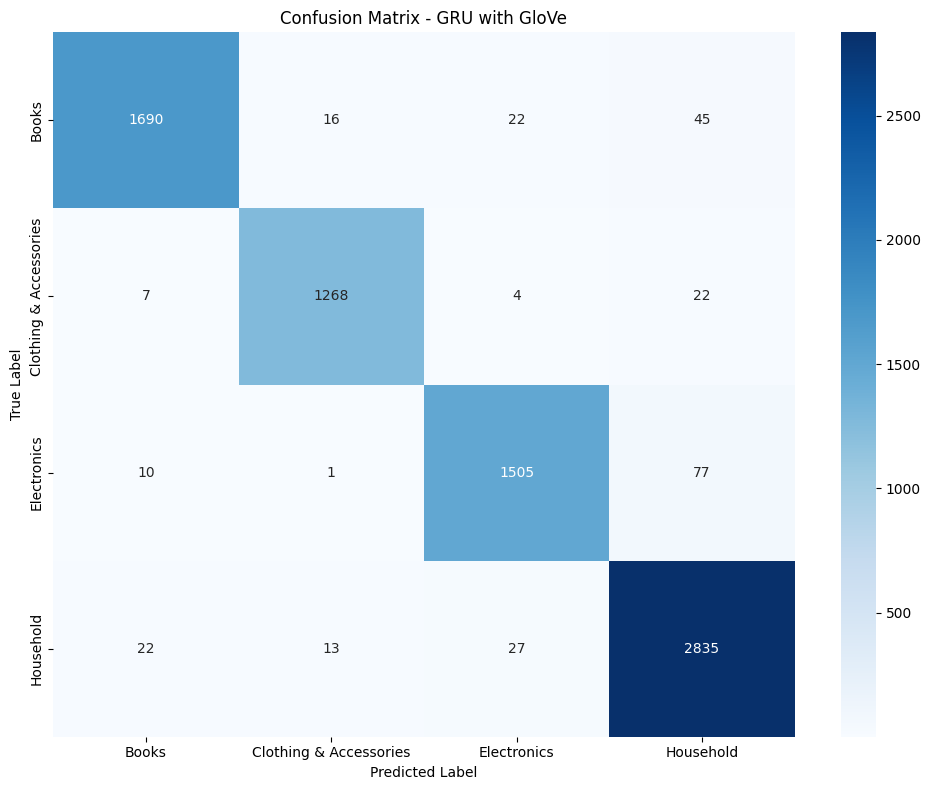

In [21]:
print("EXPERIMENT 4: GRU with GloVe")
print("="*60)

glove_path = '/content/glove.6B.100d.txt'

# Load GloVe embeddings
print("\nLoading GloVe embeddings...")
glove_index = {}

try:
    with open(glove_path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            glove_index[word] = coefs

    print(f" Loaded {len(glove_index)} word vectors")

    # Create embedding matrix
    embedding_matrix_glove = np.zeros((vocab_size, EMBEDDING_DIM))
    hits, misses = 0, 0

    for word, idx in tokenizer.word_index.items():
        if idx < vocab_size:
            embedding_vector = glove_index.get(word)
            if embedding_vector is not None:
                embedding_matrix_glove[idx] = embedding_vector
                hits += 1
            else:
                embedding_matrix_glove[idx] = np.random.normal(0, 0.1, EMBEDDING_DIM)
                misses += 1

    print(f"GloVe coverage: {hits/(hits+misses)*100:.2f}% ({hits}/{hits+misses})")

    # Create and train model
    model_glove = create_gru_model(
        vocab_size=vocab_size,
        embedding_dim=EMBEDDING_DIM,
        max_length=MAX_SEQUENCE_LENGTH,
        num_classes=num_classes,
        embedding_matrix=embedding_matrix_glove,
        trainable_embedding=False
    )

    model_glove.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print("\nTraining GRU with GloVe embeddings...")
    history_glove = model_glove.fit(
        X_train_padded, y_train_cat,
        validation_data=(X_val_padded, y_val_cat),
        epochs=20,
        batch_size=64,
        callbacks=get_callbacks(),
        verbose=1
    )

    plot_training_history(history_glove, 'GRU with GloVe')

    results_glove = evaluate_model(
        model_glove, X_test_padded, y_test_cat,
        y_test_encoded, label_encoder, 'GRU with GloVe'
    )
except FileNotFoundError:
    print(f"Error: GloVe file not found at {glove_path}. Please make sure the file is uploaded or the path is correct.")
    results_glove = None # Initialize results_glove to None if file not found
except Exception as e:
    print(f"An error occurred during GloVe processing: {e}")
    results_glove = None # Initialize results_glove to None if other error occurs

# 12. EXPERIMENT 5: GRU with FastText

EXPERIMENT 5: GRU with FastText

Training FastText...
Trained! Vocabulary size: 38097
Embedding coverage: 100.00% (14999/14999)

Training GRU with FastText embeddings...
Epoch 1/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.8684 - loss: 0.4082 - val_accuracy: 0.9455 - val_loss: 0.1905 - learning_rate: 0.0010
Epoch 2/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.9483 - loss: 0.1935 - val_accuracy: 0.9571 - val_loss: 0.1472 - learning_rate: 0.0010
Epoch 3/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.9569 - loss: 0.1669 - val_accuracy: 0.9622 - val_loss: 0.1330 - learning_rate: 0.0010
Epoch 4/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.9619 - loss: 0.1395 - val_accuracy: 0.9661 - val_loss: 0.1153 - learning_rate: 0.0010
Epoch 5/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.9678 - loss: 0.1163 - val_accuracy: 0.9629 - val_loss: 0.1200 - learning_rate: 0.0010
Epoch 6/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accu

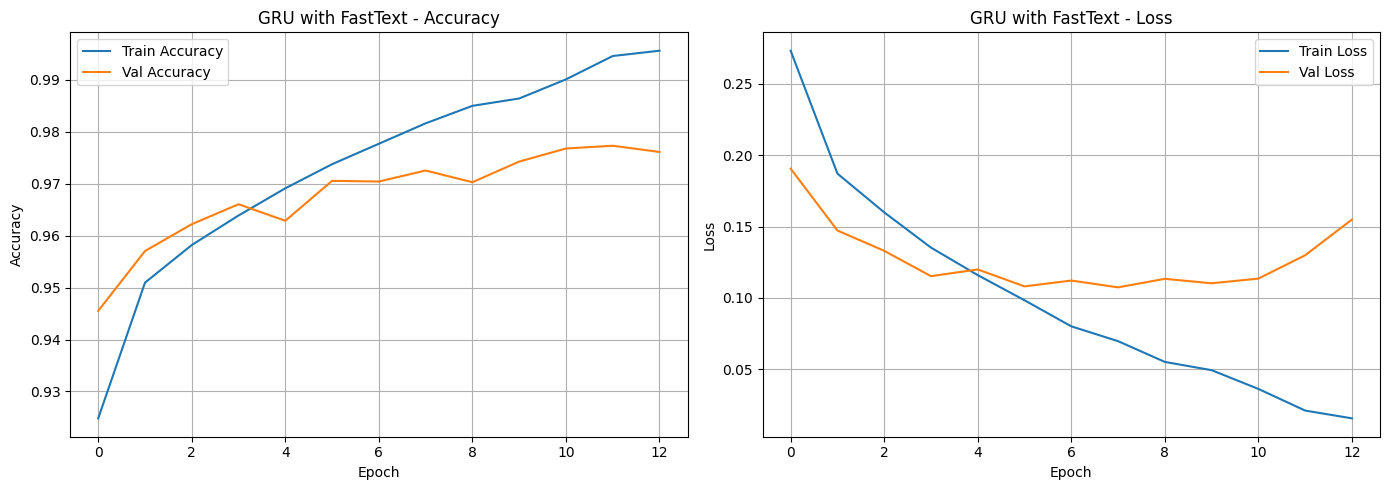


GRU with FastText - Test Results
Accuracy:  0.9741
Precision: 0.9741
Recall:    0.9741
F1-Score:  0.9741


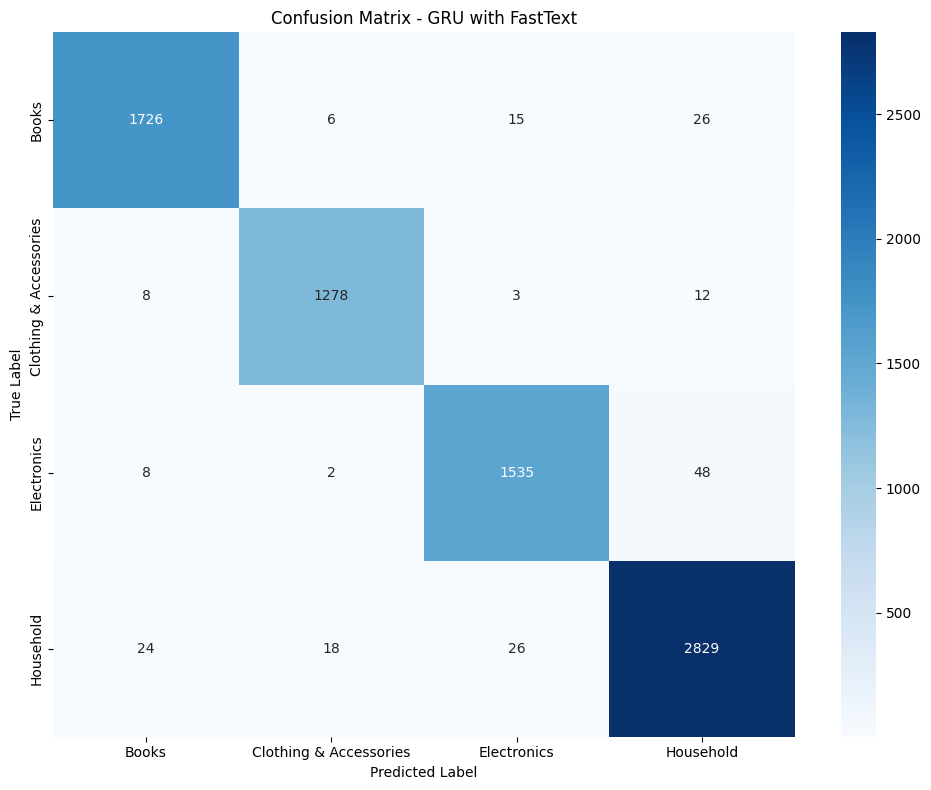

In [22]:
print("EXPERIMENT 5: GRU with FastText")
print("="*60)

# Train FastText
print("\nTraining FastText...")
fasttext_model = FastText(
    sentences=tokenized_train,
    vector_size=EMBEDDING_DIM,
    window=5,
    min_count=2,
    workers=4,
    sg=1,  # Skip-gram
    epochs=20,
    seed=42
)

print(f"Trained! Vocabulary size: {len(fasttext_model.wv)}")

# Create embedding matrix
embedding_matrix_fasttext = np.zeros((vocab_size, EMBEDDING_DIM))
hits, misses = 0, 0

for word, idx in tokenizer.word_index.items():
    if idx < vocab_size:
        try:
            embedding_matrix_fasttext[idx] = fasttext_model.wv[word]
            hits += 1
        except KeyError:
            embedding_matrix_fasttext[idx] = np.random.normal(0, 0.1, EMBEDDING_DIM)
            misses += 1

print(f"Embedding coverage: {hits/(hits+misses)*100:.2f}% ({hits}/{hits+misses})")

# Create and train model
model_fasttext = create_gru_model(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    max_length=MAX_SEQUENCE_LENGTH,
    num_classes=num_classes,
    embedding_matrix=embedding_matrix_fasttext,
    trainable_embedding=False
)

model_fasttext.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nTraining GRU with FastText embeddings...")
history_fasttext = model_fasttext.fit(
    X_train_padded, y_train_cat,
    validation_data=(X_val_padded, y_val_cat),
    epochs=20,
    batch_size=64,
    callbacks=get_callbacks(),
    verbose=1
)

plot_training_history(history_fasttext, 'GRU with FastText')

results_fasttext = evaluate_model(
    model_fasttext, X_test_padded, y_test_cat,
    y_test_encoded, label_encoder, 'GRU with FastText'
)

# 13. Final Comparison

FINAL COMPARISON - ALL EMBEDDINGS

                      model  accuracy  precision   recall  f1_score
     GRU with Word2Vec CBOW  0.975410   0.975528 0.975410  0.975401
GRU with Word2Vec Skip-gram  0.974220   0.974545 0.974220  0.974260
          GRU with FastText  0.974088   0.974093 0.974088  0.974082
       TF-IDF with Dense NN  0.972369   0.972377 0.972369  0.972361
             GRU with GloVe  0.964833   0.965060 0.964833  0.964814


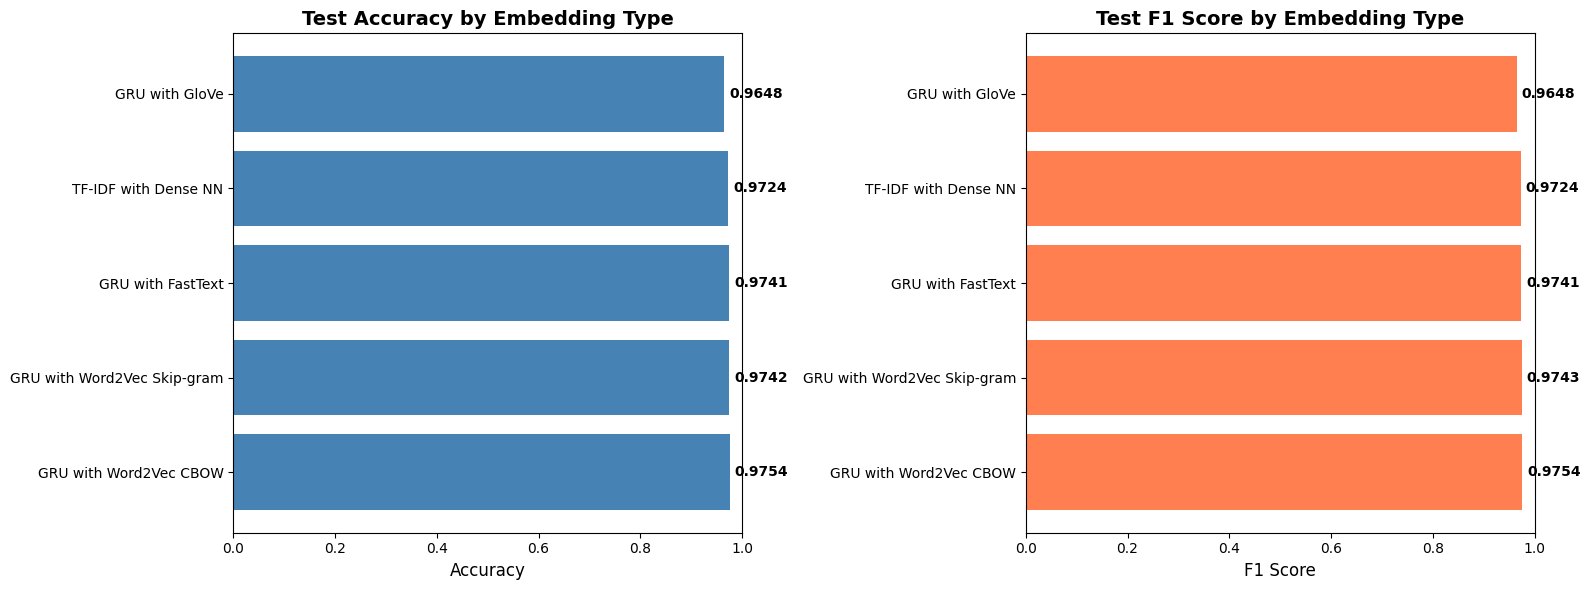

Model comparison results saved to 'model_comparison.csv'

 Comparison visualization saved as 'embedding_comparison.png'


In [25]:
print("FINAL COMPARISON - ALL EMBEDDINGS")
print("="*80)

# Collect all results
all_results = [
    results_tfidf,
    results_skipgram,
    results_cbow,
]

if results_glove is not None:
    all_results.append(results_glove)

all_results.append(results_fasttext)

# Create comparison DataFrame
comparison_df = pd.DataFrame(all_results)
comparison_df = comparison_df.sort_values('accuracy', ascending=False)

print("\n" + comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy comparison
axes[0].barh(comparison_df['model'], comparison_df['accuracy'], color='steelblue')
axes[0].set_xlabel('Accuracy', fontsize=12)
axes[0].set_title('Test Accuracy by Embedding Type', fontsize=14, fontweight='bold')
axes[0].set_xlim([0, 1])
for i, v in enumerate(comparison_df['accuracy']):
    axes[0].text(v + 0.01, i, f'{v:.4f}', va='center', fontweight='bold')

# F1 Score comparison
axes[1].barh(comparison_df['model'], comparison_df['f1_score'], color='coral')
axes[1].set_xlabel('F1 Score', fontsize=12)
axes[1].set_title('Test F1 Score by Embedding Type', fontsize=14, fontweight='bold')
axes[1].set_xlim([0, 1])
for i, v in enumerate(comparison_df['f1_score']):
    axes[1].text(v + 0.01, i, f'{v:.4f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('embedding_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
comparison_df.to_csv('model_comparison.csv', index=False)
print("Model comparison results saved to 'model_comparison.csv'")

print("\n Comparison visualization saved as 'embedding_comparison.png'")

# 14. Best Model Analysis

In [24]:
best_model_name = comparison_df.iloc[0]['model']
best_accuracy = comparison_df.iloc[0]['accuracy']

print("\n" + "="*60)
print("BEST PERFORMING MODEL")
print("="*60)
print(f"Model: {best_model_name}")
print(f"Test Accuracy: {best_accuracy:.4f}")
print(f"Test F1 Score: {comparison_df.iloc[0]['f1_score']:.4f}")
print(f"Test Precision: {comparison_df.iloc[0]['precision']:.4f}")
print(f"Test Recall: {comparison_df.iloc[0]['recall']:.4f}")



BEST PERFORMING MODEL
Model: GRU with Word2Vec CBOW
Test Accuracy: 0.9754
Test F1 Score: 0.9754
Test Precision: 0.9755
Test Recall: 0.9754
